In [1]:
import pandas as pd 
import numpy as np 
import os
import kaleido
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,StratifiedKFold

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.utils import compute_class_weight
from sklearn import metrics
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from config.path_config import ROOT_DIR
import plotly.io as pio
import matplotlib.pyplot as plt
CONFIG_PATH = ""
TARGET = "SeriousDlqin2yrs"

TRAINING_PATH = os.path.join(ROOT_DIR,"data","processed","processed_training_5_exp_tuned.csv")
WRANGLED_DATA = os.path.join(ROOT_DIR,"data","interim","interim_training_forth_exp_tuned.csv")

In [2]:
data = pd.read_csv(TRAINING_PATH)
#split into X and Y 
X = data.drop(TARGET,axis=1)
y = data[TARGET]

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

In [3]:
y


0         1
1         0
2         0
3         0
4         0
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: SeriousDlqin2yrs, Length: 150000, dtype: int64

In [4]:
#define cross validation 

fold = StratifiedKFold(5)
def begin_cross_validation(X,Y,model,fold=fold) : 
    scoring_dict = {'auc':[]}
    for train_idx,test_idx in fold.split(X,Y) : 
        train_x,val_x = X.iloc[train_idx],X.iloc[test_idx]
        train_y,val_y = Y.iloc[train_idx],Y.iloc[test_idx]
        #train model 

        model.fit(train_x,train_y)
        y_pred = model.predict_proba(val_x)
        #calculate metrics 
        scoring_dict["auc"].append(metrics.roc_auc_score(val_y, y_pred[:, 1]))


    #print the scoring 
    print(f'''Scoring: AUC :{np.mean(scoring_dict['auc'])}
     ''')
    return np.mean(scoring_dict['auc'])

In [5]:

clf_model = LGBMClassifier().fit(X,y)
begin_cross_validation(X,y,model=clf_model)

Scoring: AUC :0.8645873614338461
     


0.8645873614338461

In [6]:
weight = compute_class_weight(class_weight = 'balanced', 
                                      classes = np.unique(y_train), 
                                      y = y_train)

In [7]:
latest_params = {'lambda_l1': 0.0004979634231918787, 'lambda_l2': 8.888178821370811, 'num_leaves': 48, 'max_depth': 29, 'feature_fraction': 0.6437564293684458, 'bagging_fraction': 0.8402914515480595, 'bagging_freq': 9, 'min_child_samples': 115}

In [8]:
from src.utils.load_config import load_yaml
config_path = os.path.join(ROOT_DIR,"src","experiment_config","exp_class_weight.yaml")
params = load_yaml(config_path)["params"]
sklearn_weight = dict(zip(np.unique(y_train), weight))
#del params["class_weight"]
clf_model = LGBMClassifier(**latest_params,class_weight='balanced')
lgb_base = LGBMClassifier(class_weight='balanced')
clf_model.fit(X_train,y_train)
lgb_base.fit(X_train,y_train)

[LightGBM] [Warning] lambda_l1 is set=0.0004979634231918787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004979634231918787
[LightGBM] [Warning] feature_fraction is set=0.6437564293684458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437564293684458
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=8.888178821370811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.888178821370811
[LightGBM] [Warning] bagging_fraction is set=0.8402914515480595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402914515480595


LGBMClassifier(class_weight='balanced')

In [9]:
lgb_isotonic = CalibratedClassifierCV(clf_model, cv=fold, method="isotonic",ensemble=True)
lgb_sigmoid = CalibratedClassifierCV(clf_model, cv=fold, method="sigmoid",ensemble=True)
lgb_base_iso = CalibratedClassifierCV(lgb_base, cv=fold, method="isotonic",ensemble=True)
lgb_base_sig = CalibratedClassifierCV(lgb_base, cv=fold, method="sigmoid",ensemble=True)

lr = LogisticRegression(class_weight='balanced',max_iter=10)

In [10]:
lgb_isotonic.fit(X_train,y_train)

[LightGBM] [Warning] lambda_l1 is set=0.0004979634231918787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004979634231918787
[LightGBM] [Warning] feature_fraction is set=0.6437564293684458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437564293684458
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=8.888178821370811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.888178821370811
[LightGBM] [Warning] bagging_fraction is set=0.8402914515480595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402914515480595
[LightGBM] [Warning] lambda_l1 is set=0.0004979634231918787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004979634231918787
[LightGBM] [Warning] feature_fraction is set=0.6437564293684458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437564293684458
[LightGBM] [Warning] baggin

CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=LGBMClassifier(bagging_fraction=0.8402914515480595,
                                                bagging_freq=9,
                                                class_weight='balanced',
                                                feature_fraction=0.6437564293684458,
                                                lambda_l1=0.0004979634231918787,
                                                lambda_l2=8.888178821370811,
                                                max_depth=29,
                                                min_child_samples=115,
                                                num_leaves=48),
                       method='isotonic')

In [119]:
submission_path = os.path.join(ROOT_DIR,"data","raw","sampleEntry.csv")
TEST_PATH = os.path.join(ROOT_DIR,"data","processed","processed_5_forth_exp_tuned.csv")
test_data = pd.read_csv(TEST_PATH)
submission = pd.read_csv(submission_path)

In [121]:
pred = lgb_isotonic.predict_proba(test_data)
submission['Probability'] = pred[:, 1]
submission.to_csv('submission_weighted_class_calibrated.csv',index=False)

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] lambda_l1 is set=0.0004979634231918787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004979634231918787
[LightGBM] [Warning] feature_fraction is set=0.6437564293684458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437564293684458
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=8.888178821370811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.888178821370811
[LightGBM] [Warning] bagging_fraction is set=0.8402914515480595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402914515480595
[LightGBM] [Warning] lambda_l1 is set=0.0004979634231918787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004979634231918787
[LightGBM] [Warning] feature_fraction is set=0.6437564293684458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6437564293684458
[LightGBM] [Warning] baggin

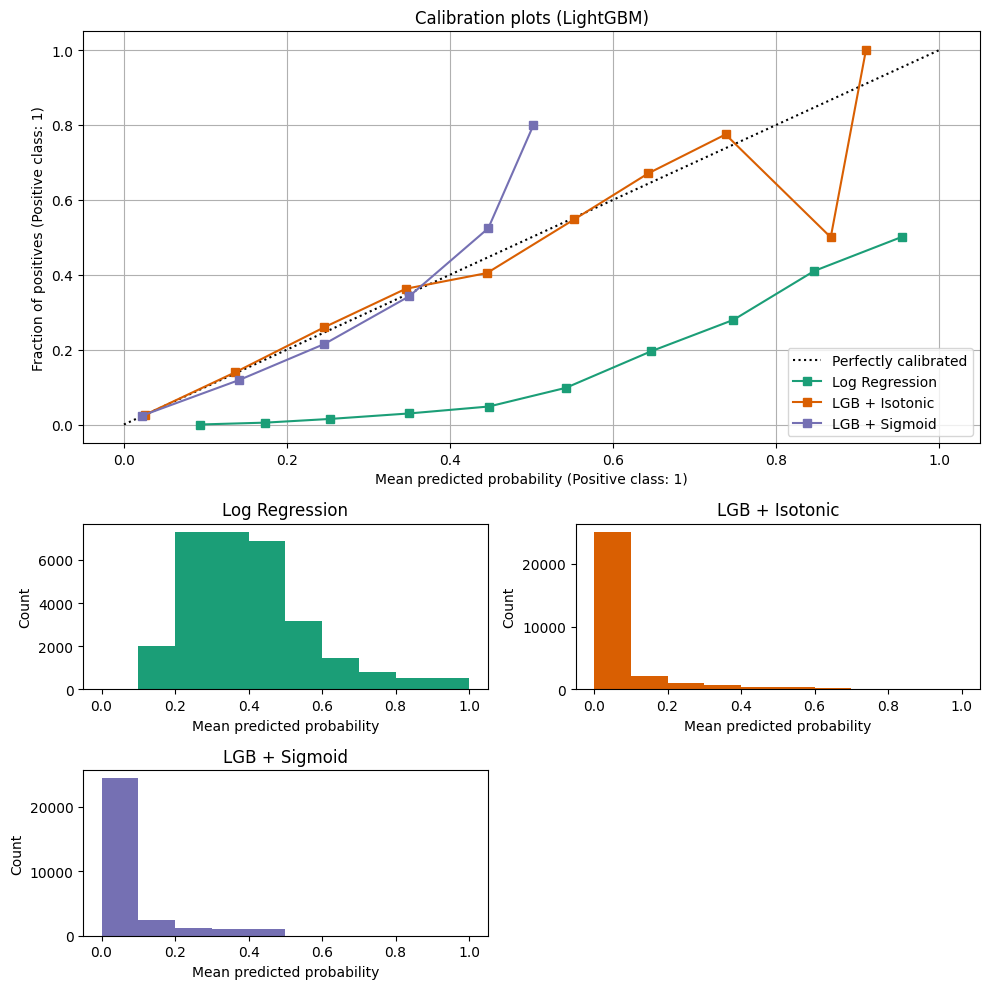

In [12]:
from matplotlib.gridspec import GridSpec
clf_list = [
    (lr,'Log Regression'),
    (lgb_isotonic, "LGB + Isotonic"),
    (lgb_sigmoid, "LGB + Sigmoid"),
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (LightGBM)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):

    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

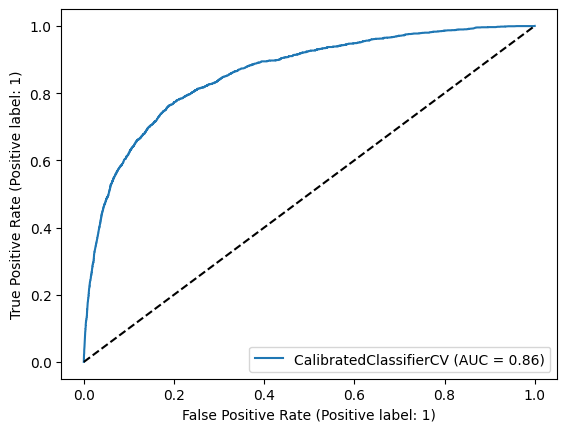

<Figure size 640x480 with 0 Axes>

In [154]:
from sklearn.metrics import RocCurveDisplay
x = RocCurveDisplay.from_estimator(
   lgb_isotonic, X_val, y_val)
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.show()
plt.savefig("LGBM ROCurve.png")

In [165]:
y_pred = lgb_isotonic.predict(X_val)
conf_metrics = metrics.confusion_matrix(y_val,y_pred)

In [170]:
metrics.accuracy_score(y_val,y_pred)

0.9371333333333334

In [175]:
y

['0', '1']

In [181]:
np.bincount(y)/np.bincount(y).sum()

array([0.93316, 0.06684])

In [172]:
np.bincount(y_val)/np.bincount(y_val).sum()



array([0.93363333, 0.06636667])

In [166]:
tn, fp, fn, tp =conf_metrics.ravel()

In [167]:
sensitivity = tn / (tn+fp)

In [168]:
1-sensitivity

0.00963975864900568

In [169]:
tp / (tp+fn)

0.18834756403817177

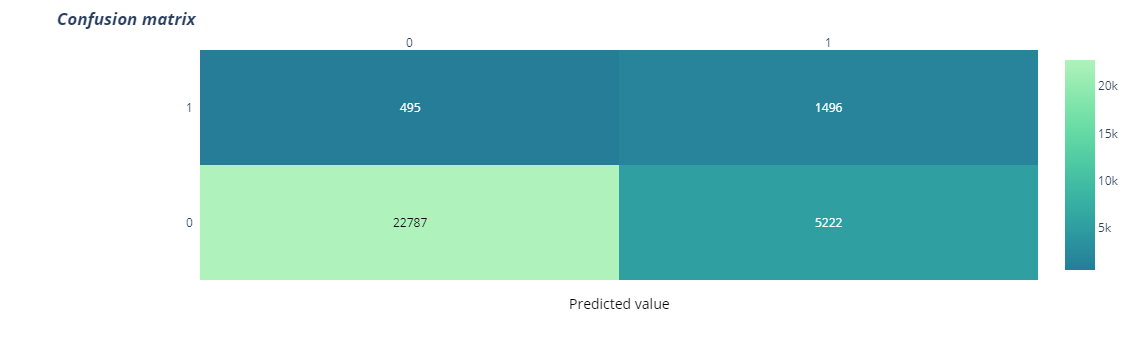

In [160]:
import plotly.figure_factory as ff



x = ['0','1']
y =  ['0','1']

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in conf_metrics]

# set up figure 
fig = ff.create_annotated_heatmap(conf_metrics, x=x, y=y, colorscale='tealgrn_r')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [ ]:
importance = permutation_importance(clf_model, X_val, y_val,
                           n_repeats=30,
                           random_state=0,
                                   scoring='roc_auc')

In [ ]:
importance_df = pd.DataFrame()
features = []
mean_importance = []
std_importance= []

In [ ]:

for i in importance['importances_mean'].argsort()[::-1]:
    if importance['importances_mean'][i] - 2 * importance['importances_std'][i] > 0:
        features.append(X.columns[i])
        mean_importance.append(importance['importances_mean'][i])
        std_importance.append(importance['importances_std'][i])
        print(f"{X.columns[i]}"
              f"{importance['importances_mean'][i]:.3f}"
              f" +/- {importance['importances_std'][i]:.3f}")

In [ ]:
importance_df = pd.DataFrame(data={"features":features,
                                   "mean_importance":mean_importance,
                                  "std_importance":std_importance})

In [ ]:
importance_df.style.highlight_max(color = 'green',subset='mean_importance')

In [ ]:
import plotly.graph_objects as go
        
fig = go.Figure()
for i in range(importance_df.shape[0]) : 
    fig.add_trace(go.Bar(
        x=[importance_df.features[i]], y=[importance_df.mean_importance[i]],
        error_y=dict(type='data', array=[importance_df.std_importance[i]])))
fig.update_layout(title='Permutation Importance',height=500,paper_bgcolor='#ffffff')

In [ ]:
fig.update_layout(title='Permutation Importance',height=500,paper_bgcolor='#ffffff')

In [ ]:
import matplotlib.pyplot as plt 
x = lgb.plot_importance(booster=clf_model)
plt.savefig('LGBM_Feature_Importance.png')